In [1]:
#import modules
import xarray as xr
import numpy as np
import pandas as pd
import salem
import plotly.graph_objects as go

import sys
sys.path.append('/exports/csce/datastore/geos/users/s1878599/python_code/')
from WRFChemToolkit.analysis import aerosols_202 as aer, plots as pt, statistics as st, IGP as igp

import warnings
warnings.filterwarnings('ignore')

#for getting only pib data
import salem
shdf= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599//python_code/gadm_data/IGP/IGP.shp")

## Create functions for calculating emissions 

In [2]:
#Functions for calcualting emissions from anthro

def emi_unirates_anthro(ds): 
   
    "Convert gas emissions rates from [mol km-2 hr-1] to [ug m-2 s-1] as aerosols"

    molw ={ "CO":28, "NO":30,"NO2":46,"SO2":64,"BIGALK":72,"BIGENE":56, "C2H4":28, "C2H5OH":46, "C2H6":30, "C3H8":44, "C3H6":42, 
            "CH2O":30, "CH3CHO":44, "CH3COCH3":58, "CH3OH":32, "MEK":72, "TOLUENE":92, "BENZENE":78,"XYLENE":106, "HONO":47,
            "NH3":17, "C10H16":136, "GLY":58, "MGLY":72, "ISOP":68, "MACR":70, 
            "MVK":70, "HCOOH":46, "C2H2":26}
    
    gug=1e+6 #g to ug.
    km2m2=1e+6 # km2 to m2.
    hrsec=3600 #hour to sec 
    conv = gug/(km2m2*hrsec) 
    dsc=ds.copy(deep=True)
    for sp in molw.keys():
        dsc["E_"+ sp]= dsc["E_"+ sp]*molw[sp]*conv  
        dsc["E_"+ sp].attrs["units"]="ug m-2 s-1"

    return dsc


def calc_emiantro(ds,sres):
    """
    Convert wrffirechemi emissions rates.
    """
    km2m2=1e+6 # km2 to m2. sres in km need to convert in m
    hrsec=3600 #hour to sec
    ugTg=1e-18 #ug to Tg
       
    ds["tot_emi"]= xr.DataArray(np.zeros(ds["E_CO"].shape), coords=ds.coords, dims=ds.dims)
   
    for da in ds.data_vars.values():
        if da.name.startswith("E_"):
            ds[da.name]=ds[da.name]*hrsec*(sres*sres)*km2m2*ugTg   #  emissions at each gridpoint at each hour.
            ds[da.name].attrs["units"]="Tg hour-1"
            
            ds["tot_emi"]=ds["tot_emi"]+ds[da.name]  #adding to total emissions.
            
    ds["tot_emi"].attrs["units"]="Tg hour-1"


## Prepare emissions difference

In [3]:
#GET ANTHROPOGENIC EMISSIONS DATA
aab_pth = '/scratch/local/caterina/WRFChem3.9.1.1/WRF/run_autumn/emi_base/wrfchemi*'
aap_pth = '/scratch/local/caterina/WRFChem3.9.1.1/WRF/run_autumn/emi_ptrb/wrfchemi*'
awb_pth = '/scratch/local/caterina/WRFChem3.9.1.1/WRF/run_winter/emi_base/wrfchemi*'
awp_pth = '/scratch/local/caterina/WRFChem3.9.1.1/WRF/run_winter/emi_ptrb/wrfchemi*'
apmb_pth = '/scratch/local/caterina/WRFChem3.9.1.1/WRF/run_premonsoon/emi_base/wrfchemi*'
apmp_pth = '/scratch/local/caterina/WRFChem3.9.1.1/WRF/run_premonsoon/emi_ptrb/wrfchemi*'
amb_pth = '/scratch/local/caterina/WRFChem3.9.1.1/WRF/run_monsoon/emi_base/wrfchemi*'
amp_pth = '/scratch/local/caterina/WRFChem3.9.1.1/WRF/run_monsoon/emi_ptrb/wrfchemi*'

aab = xr.open_mfdataset(aab_pth, concat_dim='Time')
aap = xr.open_mfdataset(aap_pth,concat_dim='Time')
awb = xr.open_mfdataset(awb_pth, concat_dim='Time')
awp = xr.open_mfdataset(awp_pth,concat_dim='Time')
apmb = xr.open_mfdataset(apmb_pth, concat_dim='Time')
apmp = xr.open_mfdataset(apmp_pth,concat_dim='Time')
amb = xr.open_mfdataset(amb_pth , concat_dim='Time')
amp = xr.open_mfdataset(amp_pth ,concat_dim='Time') 

In [4]:
# put everything in a dict by season
emi_a={"aut":[aab,aap], "win":[awb,awp],"pmon":[apmb,apmp],"mon":[amb,amp]}

In [5]:
#Calculate hourly total emissions at each gridpoint [Tg]
for v in emi_a.values():
    for ds in v:
        #print(ds.E_CO.values.max())
        
        temp=emi_unirates_anthro(ds)
        #print(temp.E_CO.values.max())
        
        calc_emiantro(temp,sres=20)
        #print(temp.E_CO.values.max())
        
        ds["tot_emi"]=temp.tot_emi
        #print(temp.tot_emi.values.max())

In [6]:
#Calculate emission difference in each zone

In [7]:
u= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599//python_code/gadm_data/IGP/U_IGP.shp")
m= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599//python_code/gadm_data/IGP/M_IGP.shp")
l= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599//python_code/gadm_data/IGP/L_IGP.shp")
shp={'upp':u,'mid':m,'low':l}

In [8]:
emi={'pmon': {}, 'mon': {}, 'aut': {}, 'win': {}}
for s in emi_a.keys():
    for k in shp.keys():
        v0igp=emi_a[s][0].salem.roi(shape=shp[k])
        v1igp=emi_a[s][1].salem.roi(shape=shp[k])
        tb= (v0igp['tot_emi'].sum(dim=['Time', 'emissions_zdim_stag','south_north','west_east'])/2).values  # 12h
        tp= (v1igp['tot_emi'].sum(dim=['Time', 'emissions_zdim_stag','south_north','west_east'])/2).values
        d=tp-tb # difference Tg
        emi[s].update({k:d})

In [9]:
emi['pmon']

{'upp': 0.07320120399900731,
 'mid': 0.08920085878363082,
 'low': 0.09505361873369744}

In [10]:
# create masks
def create_masks(ds,shp,emi):
    masks={'pmon': {}, 'mon': {}, 'aut': {}, 'win': {}}
    for s in emi.keys():
        for k in shp.keys():
            ds.PM2_5_DRY.values=(emi[s][k])*np.ones(ds.PM2_5_DRY.shape) 
            t=ds.salem.roi(shape=shp[k])  
            np.nan_to_num(t.PM2_5_DRY.values, copy=False, nan=1, posinf=0.0, neginf=0.0)
            m=t.PM2_5_DRY[0,0,:,:]
            masks[s].update({k:m})
    return masks 

In [11]:
ds= xr.open_mfdataset('/geos/d21/s1878599/IGP/outputs/autumn/wrfout_d01_2017-11-01_00:00:00_.nc')
emimsk=create_masks(ds,shp,emi)

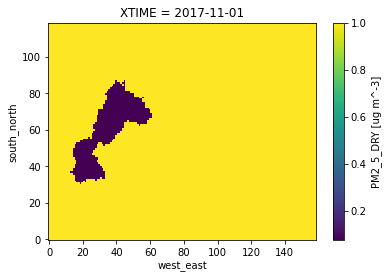

In [12]:
emimsk['pmon']['upp'].plot()

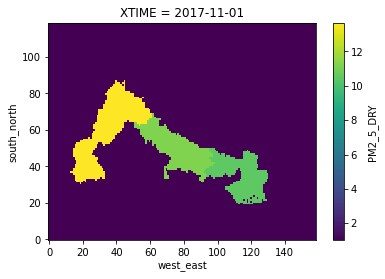

In [13]:
#test mask
a=ds.PM2_5_DRY.values=np.ones(ds.PM2_5_DRY.shape)
(a[0,0,:,:]/emimsk['pmon']['upp']/emimsk['pmon']['mid']/emimsk['pmon']['low']).plot()

In [14]:
m=1/emimsk['pmon']['upp']/emimsk['pmon']['mid']/emimsk['pmon']['low']

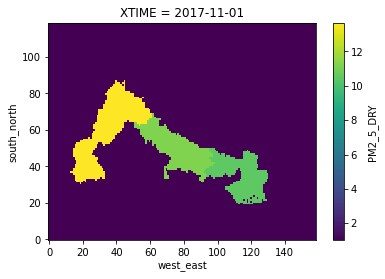

In [15]:
m.plot()

## Prepare aerosols outputs

In [16]:
# get aerosol data ALL DOMAIN for firsts 2 days
oab_pth='/geos/d21/s1878599/IGP/outputs/autumn/wrfout_d01_2017-11-01_00:00:00_.nc'
oap_pth='/geos/d21/s1878599/IGP/outputs/autumn/anthro_prtb/wrfout_d01_2017-11-01_00:00:00_ap.nc'
owb_pth='/geos/d21/s1878599/IGP/outputs/winter/wrfout_d01_2018-01-22_00:00:00_.nc'
owp_pth='/geos/d21/s1878599/IGP/outputs/winter/anthro_prtb/wrfout_d01_2018-01-22_00:00:00_ap.nc'
opmb_pth='/geos/d21/s1878599/IGP/outputs/premonsoon/wrfout_d01_2017-05-02_00:00:00.nc'
opmp_pth='/geos/d21/s1878599/IGP/outputs/premonsoon/anthro_prtb/wrfout_d01_2017-05-02_00:00:00_ap.nc'
omb_pth='/geos/d21/s1878599/IGP/outputs/monsoon/wrfout_d01_2017-07-17_00:00:00_.nc'
omp_pth='/geos/d21/s1878599/IGP/outputs/monsoon/anthro_prtb/wrfout_d01_2017-07-17_00:00:00_ap.nc'

oab= xr.open_mfdataset(oab_pth).sel(Time=slice(1,16))
oap=xr.open_mfdataset(oap_pth).sel(Time=slice(1,16)) 
owb= xr.open_mfdataset(owb_pth).sel(Time=slice(1,16))
owp=xr.open_mfdataset(owp_pth).sel(Time=slice(1,16))
opmb= xr.open_mfdataset(opmb_pth).sel(Time=slice(1,16))
opmp=xr.open_mfdataset(opmp_pth).sel(Time=slice(1,16))  
omb=xr.open_mfdataset(omb_pth).sel(Time=slice(1,16))
omp=xr.open_mfdataset(omp_pth).sel(Time=slice(1,16))

In [17]:
# put everything in a dict by season
saout={"aut":[oab,oap], "win":[owb,owp],"pmon":[opmb,opmp],"mon":[omb,omp]}

In [18]:
#get aerosols for each dataset
aaer={}
for k,v in saout.items():
    
    baer= aer.get_aerosols(v[0])
    baer.attrs=v[0].attrs
    paer= aer.get_aerosols(v[1])
    paer.attrs=v[1].attrs
    
    aaer.update({k : [baer,paer]})

## Calculate sensitivities

In [19]:
#Create function for surface sensitivity at gridpoint ij for a specified species.


def get_s_ij(bds,pds,delta_emi,var):
    """
    bds = base output
    pds = perturbed output
    delta_emi = total difference in emissions [ug/m3]
    var = variable for which calculate sensitivity.
    """
    # surface total difference in concentration over sim period [ug/m3]
    diff_var = (pds[var]-bds[var]).sum('Time')[0, :, :]
    diff_var = diff_var.clip(min=0.0)
    np.nan_to_num(diff_var, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    s = (diff_var/delta_emi['upp']/delta_emi['mid']/delta_emi['low']) #divide by local emissions
    return xr.Dataset({"sty":s},coords=dict(delta_emi['upp'].coords))

# calculate sensitivities for all season and put in a dict
def sensitivity(do,de,var):
    "do= output dict,de=emissions dict var=varname "
    shdfigp= salem.read_shapefile("/exports/csce/datastore/geos/users/s1878599/python_code/gadm_data/IGP/IGP.shp")
    s={}
    for k in do.keys():
        
        sens= get_s_ij(do[k][0],do[k][1],de[k],var) # calc sensitivity
        sens.attrs=do[k][0].attrs 
        sens_igp = sens.salem.roi(shape=shdfigp)  # get sensitivity only for IGP
        s.update({k:[sens_igp,sens]})

    return s

In [20]:
# calculate sensitivities for PM2.5
spm25=sensitivity(aaer,emimsk,"pm25_tot")

In [21]:
# calculate sensitivities for POA
sPOA=sensitivity(aaer,emimsk,"pm10_POA")

In [22]:
# calculate sensitivities for SOA
sSOA=sensitivity(aaer,emimsk,"pm10_SOA")

In [23]:
# calculate sensitivities for OA
sOA=sensitivity(aaer,emimsk,"pm10_OA")

## PLOTS

In [24]:
#SPATIAL PLOT IGP

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.colorbar import colorbar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.shapereader as shpreader

def set_formatter(axes):
    for ax in axes:
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                          linewidth=0.5, color='k', alpha=0.4, linestyle='-')
        gl.xlabels_top = False
        gl.xlabels_bottom = False
        gl.ylabels_right = False
        gl.ylocator = mticker.FixedLocator([20,25,30,35])
        
        ax.add_feature(cfeature.COASTLINE, lw=0.5)
        ax.add_feature(cfeature.BORDERS, lw=0.5)
        
    # get lon values only n the last ax
        if ax==axes[3]:
            gl.xlabels_bottom = True
    
    
def set_admin(axes, shp_path):
    for ax,shp in zip(axes,shp_path):
            admin = list(shpreader.Reader(shp).geometries())
            # Add data from Global Administrative Areas Dataset GDAM https://gadm.org/index.html
            ax.add_geometries(admin, ccrs.PlateCarree(),
                      edgecolor='black', facecolor='none', alpha=1, lw=0.5)
            


def sensplot(lat,lon,pmds,mds,ads,wds,vmin=None,vmax=None, title=None, label=None, cmap="OrRd",levs=10, 
            figsize=[7, 10],format="%.2f",save=False,spath=None,name="plot",savef='pdf', dpi=100):

    fig, axes =plt.subplots(nrows=4,ncols=1,figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})
    
    igp_shp="/exports/csce/datastore/geos/users/s1878599/python_code/gadm_data/IGP/IGP.shp"
    shp_path=(igp_shp,igp_shp,igp_shp,igp_shp)
    
    set_formatter(axes.flatten())
    set_admin(axes.flatten(), shp_path)
 
    #Getting values.
    
    vpm=pmds[:,:].values #.clip(min=0)
    #np.nan_to_num(vpm, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    vm= mds[:,:].values #.clip(min=0)
    #np.nan_to_num(vm, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    va= ads[:,:].values #.clip(min=0)
    #np.nan_to_num(va, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
    vw= wds[:,:].values #.clip(min=0)
    #np.nan_to_num(vw, copy=False, nan=0.0, posinf=0.0, neginf=0.0)
   
    import math
    if vmax is None:  # Get the max value in the array to plot.
        vmax =np.array([np.nanmax(vpm),np.nanmax(vm),np.nanmax(va),np.nanmax(vw)]).max() 
    if vmin is None:  # Get the max value in the array to plot.
        vmin =np.array([np.nanmin(vpm),np.nanmin(vm),np.nanmin(va),np.nanmin(vw)]).min()  
    print(vmin,vmax)
    levels = np.linspace(vmin, vmax, levs)  # number of levels for which divide the bar. Customise 
    print(levels)
    
    # premonsoon
    cspm=axes[0].contourf(lon,lat,vpm,transform=ccrs.PlateCarree(),cmap=cmap, vmin=vmin,vmax=vmax,levels=levels,
                            extend="both")#,locator=mticker.LogLocator())
    cspm.cmap.set_over("#800000")
    cspm.cmap.set_under("#000080")
                                                 
    # monsoon
    csm=axes[1].contourf(lon,lat,vm,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,levels=levels,
                           extend="both")#,locator=mticker.LogLocator()) 
    csm.cmap.set_over("#800000")
    csm.cmap.set_under("#000080")
    #autumn
    csa=axes[2].contourf(lon,lat,va,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,levels=levels,
                           extend="both")#,locator=mticker.LogLocator()) 
    csa.cmap.set_over("#800000")
    csa.cmap.set_under("#000080")
    #winter
    csw=axes[3].contourf(lon,lat,vw,transform=ccrs.PlateCarree(),cmap=cmap,vmin=vmin,vmax=vmax,levels=levels,
                           extend="both")#,locator=mticker.LogLocator()) 
    csw.cmap.set_over("#800000")
    csw.cmap.set_under("#000080")
    
 
    axes[0].text(-0.15, 0.55, 'PRE-MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=axes[0].transAxes)
    axes[1].text(-0.15, 0.55, 'MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=axes[1].transAxes)
    axes[2].text(-0.15, 0.55, 'POST-MONSOON', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=axes[2].transAxes)
    axes[3].text(-0.15, 0.55, 'WINTER', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor', fontsize=13,
        transform=axes[3].transAxes)
    
    fig.subplots_adjust(right=0.8,hspace=0.4)  
    cbar_ax = fig.add_axes([0.85, 0.1, 0.05, 0.8])  #[left, bottom, width, height]
    cbar= fig.colorbar(csw, cax=cbar_ax,pad=0.35,shrink=1, format=format)
    cbar.set_label(label,fontsize=13)
    cbar.ax.tick_params(labelsize='medium')

    if title is not None:
        axes[0].set_title(title, fontsize=12,pad=20)
    
    fig.tight_layout()
    
    #save
    if save:
        plt.savefig( spath + name +'.' + savef, format=savef, dpi=dpi)
    
    fig.show()

0 1989.57831829262
[   0.          104.71464833  209.42929666  314.14394499  418.85859332
  523.57324166  628.28788999  733.00253832  837.71718665  942.43183498
 1047.14648331 1151.86113164 1256.57577997 1361.29042831 1466.00507664
 1570.71972497 1675.4343733  1780.14902163 1884.86366996 1989.57831829]


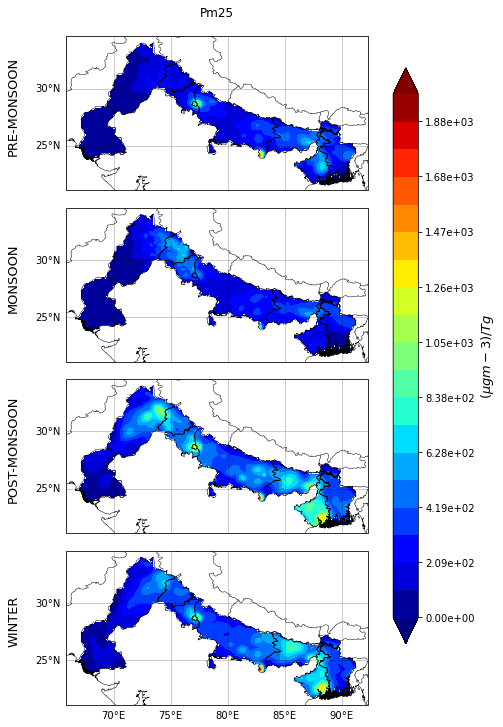

In [25]:
#Plot
lon =spm25["aut"][0].XLONG[:, :]
lat =spm25["aut"][0].XLAT[:, :]

sensplot(lat,lon,spm25["pmon"][0].sty,spm25["mon"][0].sty,spm25["aut"][0].sty,spm25["win"][0].sty,vmin=0,cmap="jet",label="$(\mu g m-3)/Tg $",title="Pm25",
        levs=20,format="%.2e",figsize=[7,10]) #,savef='pdf', dpi=300,"$(\mu g m-3)$")

0 455.8668221435195
[  0.          23.99299064  47.98598128  71.97897192  95.97196256
 119.9649532  143.95794383 167.95093447 191.94392511 215.93691575
 239.92990639 263.92289703 287.91588767 311.90887831 335.90186895
 359.89485959 383.88785023 407.88084087 431.8738315  455.86682214]


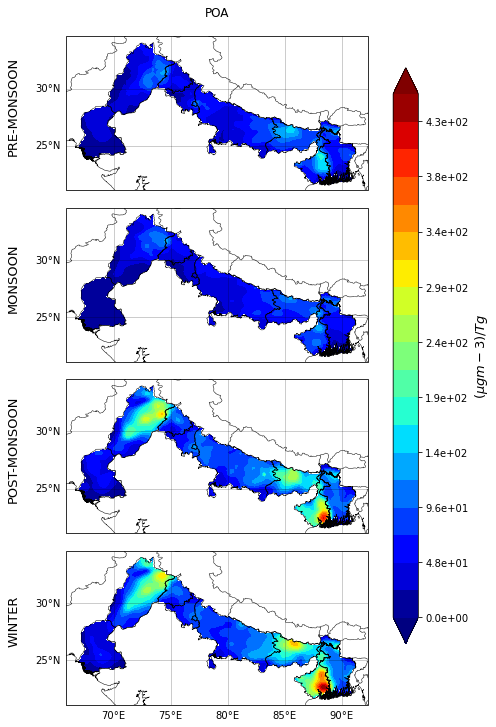

In [26]:
savepth=''
sensplot(lat,lon,sPOA["pmon"][0].sty,sPOA["mon"][0].sty,sPOA["aut"][0].sty,sPOA["win"][0].sty,cmap="jet",vmin=0, label="$(\mu g m-3)/Tg$",title="POA",
        levs=20,format="%.1e",figsize=[7,10],save=False, spath=savepth,name="sens_POA",savef='pdf', dpi=100)

0 522.7514877358876
[  0.          27.5132362   55.02647239  82.53970859 110.05294479
 137.56618098 165.07941718 192.59265338 220.10588957 247.61912577
 275.13236197 302.64559816 330.15883436 357.67207056 385.18530675
 412.69854295 440.21177915 467.72501534 495.23825154 522.75148774]


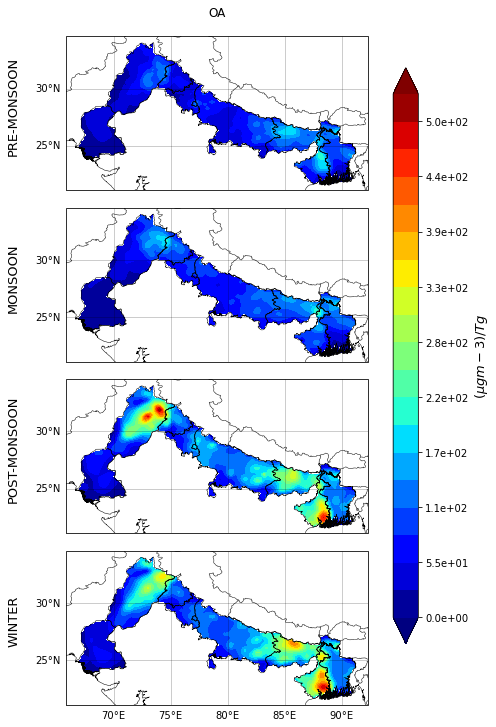

In [27]:
sensplot(lat,lon,sOA["pmon"][0].sty,sOA["mon"][0].sty,sOA["aut"][0].sty,sOA["win"][0].sty,cmap="jet",vmin=0,label="$(\mu g m-3)/Tg$",title="OA",
        levs=20,format="%.1e",figsize=[7,10],save=False, spath=savepth,name="sens_OA",savef='pdf', dpi=100)

0 258.6737939491933
[  0.          13.61441021  27.22882042  40.84323062  54.45764083
  68.07205104  81.68646125  95.30087145 108.91528166 122.52969187
 136.14410208 149.75851229 163.37292249 176.9873327  190.60174291
 204.21615312 217.83056333 231.44497353 245.05938374 258.67379395]


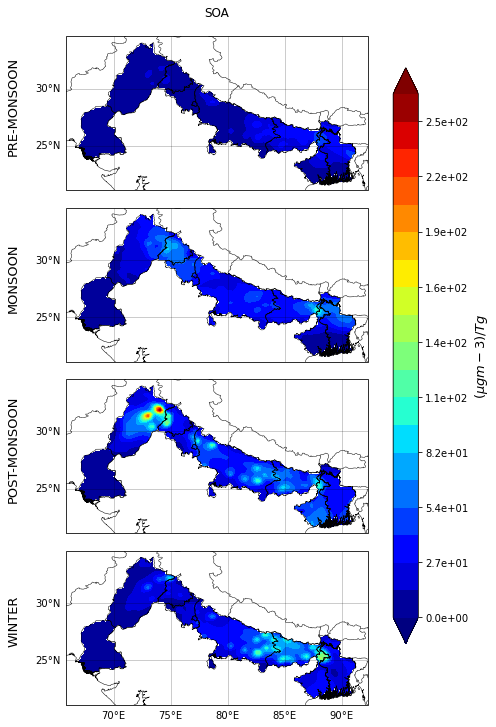

In [28]:
sensplot(lat,lon,sSOA["pmon"][0].sty,sSOA["mon"][0].sty,sSOA["aut"][0].sty,sSOA["win"][0].sty,cmap="jet",vmin=0,label="$(\mu g m-3)/Tg$",title="SOA",
        levs=20,format="%.1e",figsize=[7,10],save=False, spath=savepth,name="sens_OA",savef='pdf', dpi=100)